In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, mannwhitneyu, skew

from sklearn.datasets import make_classification

In [12]:
def evaluate_groups(
    df, 
    target_col='target', 
    value_col='gross_summ', 
    n_iter=100, 
    bootstrap_size=None, 
    plot=True, 
    alternative="two-sided"
):
    """
    Оцінює різницю між двома групами (target vs control) за допомогою бутстрепу 
    та статистичних тестів (t-тест і критерій Манна-Вітні).
    
    Параметри
    ---------
    df : pandas.DataFrame
        Вхідний датафрейм з даними, що містить стовпці для групування та метрики.
    
    target_col : str, за замовчуванням 'target'
        Назва стовпця, що визначає групу. 
        Очікується, що там є два значення: 
        - 1 для target (експериментальної групи),
        - 0 для control (контрольної групи).
    
    value_col : str, за замовчуванням 'gross_summ'
        Назва стовпця з метрикою/значеннями, які потрібно порівняти між групами.
    
    n_iter : int, за замовчуванням 100
        Кількість ітерацій бутстрепу (перегенерацій випадкових вибірок).
    
    bootstrap_size : int або None, за замовчуванням None
        Розмір випадкової вибірки для бутстрепу. 
        Якщо None → використовується 1/10 від розміру всього датафрейму.
    
    plot : bool, за замовчуванням True
        Якщо True → будується гістограма розподілу різниць середніх, 
        з позначенням середнього значення та довірчого інтервалу.
    
    alternative : {'two-sided', 'greater', 'less'}, за замовчуванням 'two-sided'
        Тип статистичного тесту:
        - 'two-sided' → перевіряється, чи відрізняються середні (будь-який напрямок).
        - 'greater' → перевіряється, чи середнє у групі target > control.
        - 'less' → перевіряється, чи середнє у групі target < control.
    
    Повертає
    --------
    pandas.DataFrame
        Таблиця з результатами оцінки, яка містить:
        - Metric/Field : назва метрики (value_col),
        - Mean Difference : середня різниця між групами (target - control),
        - CI Lower : нижня межа 95% бутстрепного довірчого інтервалу,
        - CI Upper : верхня межа 95% бутстрепного довірчого інтервалу,
        - T-test p-value (...) : p-value для t-тесту з відповідним `alternative`,
        - Mann-Whitney p-value (...) : p-value для тесту Манна-Вітні з відповідним `alternative`.
        - Cohen's d : стандартізований ефект (сила ефекту)
            - ≈0 → дуже слабкий ефект
            - 0.2 → малий ефект
            - 0.5 → середній ефект
            - 0.8 → великий ефект
        - target_mean / control_mean : середнє значення для кожної групи
        - target_median / control_median : медіана для кожної групи
        - target_std / control_std : стандартне відхилення
        - target_var / control_var : дисперсія
        - target_min / control_min : мінімум
        - target_max / control_max : максимум
        - target_skew / control_skew : асиметрія розподілу
            - ≈0 → симетричний розподіл
            - >0 → права «хвістова» асиметрія (значення з великими викидами)
            - <0 → ліва «хвістова» асиметрія (значення з маленькими викидами)
        - target_kurtosis / control_kurtosis : куртозис
            - ≈0 → розподіл схожий на нормальний
            - >0 → гострий пік та важкі хвости (часто екстремальні значення)
            - <0 → плоский розподіл, легкі хвости

    графік (якщо plot=True)
        - Гістограма розподілу різниць середніх з позначенням середнього та довірчого інтервалу.
        Якщо нуль поза межами довірчого інтервалу → можна вважати, що різниця статистично значуща.

    Зауваження
    ----------
    - Бутстреп дає емпіричний розподіл різниць середніх, що дозволяє оцінити довірчий інтервал.
    - t-тест вважає, що дані приблизно нормально розподілені, хоча може бути стійким до відхилень.
    - Критерій Манна-Вітні не робить припущень про нормальність і підходить для порівняння медіан.
    - Усі p-value за замовчуванням двосторонні, якщо не вказати інше через `alternative`.
    
    Приклади
    --------
    >>> evaluate_groups(df, value_col="revenue", alternative="two-sided")
    >>> evaluate_groups(df, value_col="deposit", n_iter=500, alternative="greater", plot=False)
    """

    tr_values = df[df[target_col] == 1][value_col].values
    co_values = df[df[target_col] == 0][value_col].values

    if not bootstrap_size:
        bootstrap_size = int(len(df) / 10)

    diffs = []
    for _ in range(n_iter):
        tr_sample = np.random.choice(tr_values, size=bootstrap_size, replace=True)
        co_sample = np.random.choice(co_values, size=bootstrap_size, replace=True)
        diff = tr_sample.mean() - co_sample.mean()
        diffs.append(diff)

    mean_diff = np.mean(diffs)
    
    if alternative == "two-sided":
        ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])
    elif alternative == "greater":  # target > control
        ci_lower = np.percentile(diffs, 5)
        ci_upper = np.inf
    else:  # 'less', target < control
        ci_lower = -np.inf
        ci_upper = np.percentile(diffs, 95)

    # t-test з вибором хвостів
    t_stat, t_p = ttest_ind(tr_values, co_values, alternative=alternative)

    # Mann-Whitney з вибором хвостів
    mw_stat, mw_p = mannwhitneyu(tr_values, co_values, alternative=alternative)

    cohen_d = (np.mean(tr_values) - np.mean(co_values)) / np.sqrt((np.var(tr_values) + np.var(co_values))/2)

    # Статистика груп
    stats = {
        'target_mean': np.mean(tr_values),
        'control_mean': np.mean(co_values),
        'target_median': np.median(tr_values),
        'control_median': np.median(co_values),
        'target_std': np.std(tr_values, ddof=1),
        'control_std': np.std(co_values, ddof=1),
        'target_var': np.var(tr_values, ddof=1),
        'control_var': np.var(co_values, ddof=1),
        'target_min': np.min(tr_values),
        'control_min': np.min(co_values),
        'target_max': np.max(tr_values),
        'control_max': np.max(co_values),
        'target_skew': skew(tr_values),
        'control_skew': skew(co_values),
        'target_kurtosis': pd.Series(tr_values).kurtosis(),
        'control_kurtosis': pd.Series(co_values).kurtosis(),
    }

    result = {
        'Metric/Field': value_col,
        'Mean Difference': round(mean_diff, 3),
        'CI Lower': round(ci_lower, 3),
        'CI Upper': round(ci_upper, 3),
        f'T-test p-value ({alternative})': round(t_p, 3),
        f'Mann-Whitney p-value ({alternative})': round(mw_p, 3),
        "Cohen's d": round(cohen_d, 3),
        **{k: round(v,3) for k,v in stats.items()}
    }
    result = pd.DataFrame(result, index=[0]).T.round(3)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.hist(diffs, bins=40, color='skyblue', edgecolor='black')
        plt.axvline(mean_diff, color='red', linestyle='--', label=f'Mean diff: {mean_diff:.2f}')
        plt.axvline(ci_lower, color='green', linestyle=':')
        plt.axvline(ci_upper, color='green', linestyle=':')

        plt.axvspan(ci_lower if np.isfinite(ci_lower) else min(diffs),
                    ci_upper if np.isfinite(ci_upper) else max(diffs),
                    color='lightgreen', alpha=0.15, label='95% CI')

        plt.title(f'Bootstrap distribution of mean diff ({value_col})')
        plt.xlabel('Difference')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return result

In [13]:
# Класичні класифікаційні дані
X, y = make_classification(
    n_samples=10000,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=4,
    random_state=42
)

# Робимо gross_summ з легкою різницею між класами
gross_summ = X[:, 0]*50 + np.random.normal(0, 15, size=10000)  # більше шуму
gross_summ += np.where(y==1, 25, 0)  # слабкий ефект для класу 1

df_fake = pd.DataFrame({
    'user_id': np.random.randint(1, 200, size=10000),
    'gross_summ': np.abs(gross_summ),
    'target': y
})

df_fake.head()

,user_id,gross_summ,target
0,52,42.025822,0
1,36,37.063897,0
2,122,17.039558,1
3,120,10.075124,0
4,185,81.589072,1


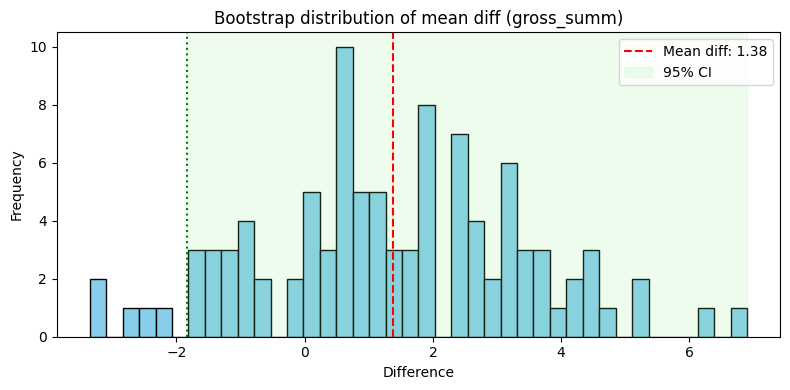

,0
Metric/Field,gross_summ
Mean Difference,1.381
CI Lower,-1.828
CI Upper,inf
T-test p-value (greater),0.031
Mann-Whitney p-value (greater),0.16
Cohen's d,0.037
target_mean,63.532
control_mean,61.856
target_median,55.806


In [14]:
evaluate_groups(df_fake, alternative="greater")

In [15]:
df_fake.groupby('target').gross_summ.describe().T

target,0,1
count,5000.000000,5000.000000
mean,61.855550,63.532436
std,43.561268,45.988615
min,0.017569,0.020423
25%,26.896624,26.073377
50%,54.909514,55.806483
75%,89.116975,92.354843
max,255.953909,323.014552
